In [6]:
import os
import json
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

plt.rc('font',family='Times New Roman')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
cur_palette = sns.color_palette()
sns.set(style='white', font='Times New Roman')

In [92]:
prefix = './'
dataset = 'ASSISTments_12-13_Core-10'
inter_df = pd.read_csv(os.path.join(prefix, dataset, 'interactions.csv'), sep='\t')
with open(os.path.join(prefix, dataset, 'skill_name.json')) as fp:
    skill2name = json.load(fp)

In [93]:
inter_df.head()

,Unnamed: 0,teacher_id,first_action,problem_type,timestamp,problem_id,dwell_time,tutor_mode,original,user_id,school_id,skill_id,correct
0,1,0,0,1,1.371614e+09,1,24.0,0,0,0,0,0,1.0
1,8,1,0,1,1.347427e+09,8,68.0,0,0,1,1,6,1.0
2,19,1,0,1,1.348406e+09,19,179.0,0,0,1,1,5,0.0
3,20,1,0,1,1.348406e+09,20,84.0,0,0,1,1,5,1.0
4,21,1,0,1,1.348406e+09,21,37.0,0,0,1,1,5,1.0


In [94]:
skill2name

{'0': 'Equation Solving Two or Fewer Steps',
 '1': 'Addition and Subtraction Integers',
 '2': 'Addition and Subtraction Fractions',
 '3': 'Conversion of Fraction Decimals Percents',
 '4': 'Multiplication and Division Integers',
 '5': 'Multiplication and Division Positive Decimals',
 '6': 'Order of Operations All',
 '7': 'Multiplication Fractions',
 '8': 'Division Fractions',
 '9': 'Equation Solving More Than Two Steps'}

## Prerequisite Score

In [121]:
skill_embeddings = joblib.load('{}/{}/alpha_inter_embeddings.npy'.format(prefix, dataset))
target_embeddings = joblib.load('{}/{}/alpha_skill_embeddings.npy'.format(prefix, dataset))
beta_skill_embeddings = joblib.load('{}/{}/beta_inter_embeddings.npy'.format(prefix, dataset))
beta_target_embeddings = joblib.load('{}/{}/beta_skill_embeddings.npy'.format(prefix, dataset))
problem_base = joblib.load('{}/{}/problem_base.npy'.format(prefix, dataset)).squeeze()
skill_base = joblib.load('{}/{}/skill_base.npy'.format(prefix, dataset)).squeeze()

In [103]:
skill_num = len(skill_base)
inter_matrix = np.zeros((skill_num * 2, skill_num))
beta_matrix = np.zeros((skill_num * 2, skill_num))
for i in range(skill_num * 2):
    for j in range(skill_num):
        inter_matrix[i][j] = np.sum(skill_embeddings[i] * target_embeddings[j])
        beta_matrix[i][j] = np.sum(beta_skill_embeddings[i] * beta_target_embeddings[j])

In [122]:
def softmax(a):
    return np.exp(a) / np.sum(np.exp(a))

for i in range(skill_num):
    score = softmax(inter_matrix[skill_num + i, :]) / softmax(inter_matrix[:skill_num, i])
    indice = np.argsort(score)[::-1]
    print(i, skill2name[str(i)], end='\n\n')
    print('Probably prerequisite:')
    for k in range(skill_num):
        if indice[k] == i or skill2name[str(indice[k])] == '':
            continue
        print('-', '{:<2d}'.format(indice[k]), '{:<.2f}'.format(score[indice[k]]), 
              skill2name[str(indice[k])])
    print()

0 Equation Solving Two or Fewer Steps

Probably prerequisite:
- 3  1.45 Conversion of Fraction Decimals Percents
- 1  1.39 Addition and Subtraction Integers
- 9  1.03 Equation Solving More Than Two Steps
- 8  1.03 Division Fractions
- 2  0.91 Addition and Subtraction Fractions
- 7  0.74 Multiplication Fractions
- 6  0.66 Order of Operations All
- 4  0.51 Multiplication and Division Integers
- 5  0.26 Multiplication and Division Positive Decimals

1 Addition and Subtraction Integers

Probably prerequisite:
- 0  0.00 Equation Solving Two or Fewer Steps
- 4  0.00 Multiplication and Division Integers
- 3  0.00 Conversion of Fraction Decimals Percents
- 8  0.00 Division Fractions
- 6  0.00 Order of Operations All
- 5  0.00 Multiplication and Division Positive Decimals
- 2  0.00 Addition and Subtraction Fractions
- 7  0.00 Multiplication Fractions
- 9  0.00 Equation Solving More Than Two Steps

2 Addition and Subtraction Fractions

Probably prerequisite:
- 7  0.10 Multiplication Fractions
- 

## Ablation Plot

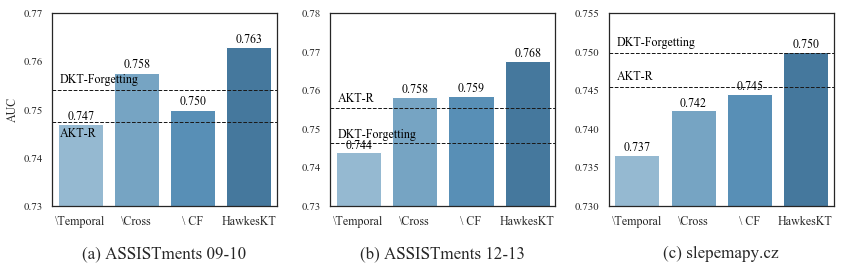

In [120]:
data = [
    [0.7469, 0.7576, 0.7500, 0.7629], 
    [0.7439, 0.7582, 0.7586, 0.7676], 
    [0.7366, 0.7424, 0.7445, 0.7500]
]
ymin = [0.73, 0.73, 0.73]
ymax = [0.77, 0.78, 0.755]
baseline = {
    'DKT-Forgetting': [0.7540, 0.7462, 0.7498],
    'AKT-R': [0.7474, 0.7555, 0.7454]
}
xticks = ['\Temporal', '\Cross', '\ CF', 'HawkesKT']
title = ['(a) ASSISTments 09-10', '(b) ASSISTments 12-13', '(c) slepemapy.cz']
palette = sns.color_palette("Blues_d", n_colors=6)
palette.reverse()

plt.figure(figsize=(12, 4))
for i in range(3):
    df = pd.DataFrame(data={'AUC': data[i], 'method': xticks})
    ax = plt.subplot(1, 3, i + 1)
    
    xs = np.arange(-0.5, 4, 0.5)
    for b in baseline.keys():
        plt.plot(xs, np.ones_like(xs) * baseline[b][i], 'k--', linewidth=1)
        text_offset = -0.003 if i == 0 and b == 'AKT-R' else 0.0015
        text_offset = 0.001 if i == 2 else text_offset
        ax.text(-0.36, baseline[b][i] + text_offset, b, color='black', fontsize=12)
    sns.barplot(x='method', y='AUC', data=df, palette=palette, ax=ax)
    plt.xticks(np.arange(len(data[i])), xticks, rotation=0, fontsize=12)
    plt.ylim(bottom=ymin[i], top=ymax[i])
    plt.xlabel('')
        
    for j, v in enumerate(data[i]):
        v_offset = 0.0005 if i == 2 else 0.001
        ax.text(j-0.23, v + v_offset, '{:<.3f}'.format(v), color='black', fontsize=12)
    if i > 0:
        plt.ylabel('')
    plt.title(title[i], y=-0.3, fontsize=17)
    
plt.tight_layout()
plt.savefig('../plot/ablation.pdf', dpi=600)
plt.show()